# RL Benchmark: Vanilla DQN vs Double DQN vs A2C vs PPO (LunarLander-v3)

This notebook runs the 4 provided scripts one by one (without variable-name collisions),
logs rewards, plots performance, and records short evaluation videos for each algorithm.


In [ ]:
# --- System deps for Box2D environments (LunarLander) ---
!apt-get -qq update
!apt-get -qq install -y swig

# --- Python deps ---
!pip -q install gymnasium[box2d] pygame pandas matplotlib


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package swig4.0.
(Reading database ... 117540 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubuntu1_all.deb ...
Unpacking swig (4.0.2-1ubuntu1) ...
Setting up swig4.0 (4.0.2-1ubuntu1) ...
Setting up swig (4.0.2-1ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 79.1 MB/s eta 0:00:00


In [ ]:
import torch, sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Torch: 2.9.0+cpu
CUDA available: False


In [ ]:
from google.colab import files
uploaded = files.upload()

# Expected filenames:
# 1_vanilla_dqn.py
# 2_double_dqn.py
# 3_a2c.py
# 4_ppo.py


Saving 1_vanilla_dqn.py to 1_vanilla_dqn.py
Saving 2_double_dqn.py to 2_double_dqn.py
Saving 3_a2c.py to 3_a2c.py
Saving 4_ppo.py to 4_ppo.py


In [ ]:
from pathlib import Path

SCRIPT_PATHS = {
    "vanilla_dqn": Path("1_vanilla_dqn.py"),
    "double_dqn":  Path("2_double_dqn.py"),
    "a2c":         Path("3_a2c.py"),
    "ppo":         Path("4_ppo.py"),
}

missing = [k for k,p in SCRIPT_PATHS.items() if not p.exists()]
if missing:
    raise FileNotFoundError(
        "Missing files: " + ", ".join(missing) +
        "\nMake sure you uploaded: 1_vanilla_dqn.py, 2_double_dqn.py, 3_a2c.py, 4_ppo.py"
    )

for k,p in SCRIPT_PATHS.items():
    print(f"{k}: {p.resolve()}")


vanilla_dqn: /content/1_vanilla_dqn.py
double_dqn: /content/2_double_dqn.py
a2c: /content/3_a2c.py
ppo: /content/4_ppo.py


In [ ]:
import os, re, time, io, builtins, runpy, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def set_global_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

class PrintCapture:
    """
    Captures episode rewards and eval rewards by parsing printed lines like:
      Episode  123 | Reward:   -30.5
        → Eval: 120.3 ± 15.2
    while still printing to the notebook output.
    """
    EP_RE = re.compile(r"Episode\s+(\d+)\s*\|\s*Reward:\s*([-\d\.]+)")
    EV_RE = re.compile(r"(?:→|->)\s*Eval:\s*([-\d\.]+)\s*±\s*([-\d\.]+)")

    def __init__(self):
        self.orig_print = None
        self.episode_rows = []  # (episode, reward)
        self.eval_rows = []     # (episode_at_time, mean, std)
        self._last_episode_seen = None

    def __enter__(self):
        self.orig_print = builtins.print

        def patched_print(*args, **kwargs):
            text = " ".join(str(a) for a in args)

            # Parse episode reward lines
            m = self.EP_RE.search(text)
            if m:
                ep = int(m.group(1))
                rw = float(m.group(2))
                self._last_episode_seen = ep
                self.episode_rows.append((ep, rw))

            # Parse eval lines
            m2 = self.EV_RE.search(text)
            if m2:
                mean = float(m2.group(1))
                std = float(m2.group(2))
                ep = self._last_episode_seen
                self.eval_rows.append((ep, mean, std))

            # Still show output
            self.orig_print(*args, **kwargs)

        builtins.print = patched_print
        return self

    def __exit__(self, exc_type, exc, tb):
        builtins.print = self.orig_print
        return False  # do not suppress exceptions

def load_script_namespace(script_path: Path) -> dict:
    """
    Loads a .py file into an isolated namespace dict, WITHOUT running main()
    (because __name__ won't be '__main__' when using runpy.run_path).
    """
    ns = runpy.run_path(str(script_path))
    return ns

def apply_overrides(ns: dict, overrides: dict):
    for k,v in overrides.items():
        ns[k] = v

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)


In [ ]:
from dataclasses import dataclass

@dataclass
class RunResult:
    alg_name: str
    out_dir: Path
    model_path: Path
    metrics_csv: Path
    df: pd.DataFrame
    elapsed_sec: float

def run_training(alg_name: str, script_path: Path, overrides: dict, root_out: Path, seed: int) -> RunResult:
    set_global_seeds(seed)

    out_dir = root_out / alg_name
    ensure_dir(out_dir)

    # Load isolated namespace
    ns = load_script_namespace(script_path)

    # Force model to save into the algorithm folder
    model_path = out_dir / f"{alg_name}_best.pt"
    overrides = dict(overrides)  # copy
    overrides["MODEL_NAME"] = str(model_path)

    # Apply overrides (ENV_ID, MAX_EPISODES, EVAL_EVERY, etc.)
    apply_overrides(ns, overrides)

    # Run training and capture prints for metrics
    start = time.time()
    cap = PrintCapture()
    with cap:
        ns["main"]()
    elapsed = time.time() - start

    # Build metrics dataframe
    ep_df = pd.DataFrame(cap.episode_rows, columns=["episode", "train_reward"]).drop_duplicates("episode")
    ev_df = pd.DataFrame(cap.eval_rows, columns=["episode", "eval_mean", "eval_std"]).drop_duplicates("episode")

    df = ep_df.merge(ev_df, on="episode", how="left").sort_values("episode").reset_index(drop=True)

    metrics_csv = out_dir / "metrics.csv"
    df.to_csv(metrics_csv, index=False)

    print(f"\n[{alg_name}] done in {elapsed/60:.1f} min")
    print(f"[{alg_name}] metrics saved to: {metrics_csv}")
    print(f"[{alg_name}] best model path (expected): {model_path}")
    if not model_path.exists():
        print(f"[{alg_name}] WARNING: best model file not found yet. "
              f"Tip: ensure MAX_EPISODES >= EVAL_EVERY so a 'best' model gets saved.")
    return RunResult(alg_name, out_dir, model_path, metrics_csv, df, elapsed)


In [ ]:
def plot_training_curves(results: dict):
    plt.figure()
    for alg, rr in results.items():
        if len(rr.df) == 0:
            continue
        plt.plot(rr.df["episode"], rr.df["train_reward"], label=f"{alg} (train)")
    plt.xlabel("Episode")
    plt.ylabel("Episode reward")
    plt.title("Training reward per episode")
    plt.legend()
    plt.show()

def plot_eval_curves(results: dict):
    plt.figure()
    for alg, rr in results.items():
        d = rr.df.dropna(subset=["eval_mean"])
        if len(d) == 0:
            continue
        plt.plot(d["episode"], d["eval_mean"], marker="o", label=f"{alg} (eval mean)")
    plt.xlabel("Episode")
    plt.ylabel("Eval mean reward")
    plt.title("Evaluation reward over training")
    plt.legend()
    plt.show()

def summary_table(results: dict) -> pd.DataFrame:
    rows = []
    for alg, rr in results.items():
        df = rr.df
        best_train = df["train_reward"].max() if len(df) else np.nan
        eval_df = df.dropna(subset=["eval_mean"])
        best_eval = eval_df["eval_mean"].max() if len(eval_df) else np.nan
        last_eval = eval_df["eval_mean"].iloc[-1] if len(eval_df) else np.nan
        rows.append({
            "algorithm": alg,
            "episodes_logged": int(df["episode"].max()) if len(df) else 0,
            "best_train_reward": best_train,
            "best_eval_mean": best_eval,
            "last_eval_mean": last_eval,
            "elapsed_min": rr.elapsed_sec / 60.0,
            "metrics_csv": str(rr.metrics_csv),
            "model_path": str(rr.model_path),
        })
    return pd.DataFrame(rows).sort_values("best_eval_mean", ascending=False)


In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML, display

def load_model_for_rollout(ns: dict, env_id: str, model_path: Path):
    device = ns.get("device", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    env = gym.make(env_id)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n
    env.close()

    if "DQN" in ns:  # DQN scripts
        model = ns["DQN"](obs_dim, n_actions).to(device)
    else:            # A2C / PPO scripts
        model = ns["ActorCritic"](obs_dim, n_actions).to(device)

    sd = torch.load(model_path, map_location=device)
    model.load_state_dict(sd)
    model.eval()
    return model, device

@torch.no_grad()
def select_action(ns: dict, model, obs: np.ndarray, device):
    x = torch.tensor([obs], dtype=torch.float32, device=device)

    if "DQN" in ns:
        q = model(x)
        return int(torch.argmax(q, dim=1).item())

    # Actor-critic: forward returns (logits, value)
    logits, _ = model(x)
    probs = torch.softmax(logits, dim=-1)
    return int(torch.argmax(probs, dim=-1).item())

def record_video(ns: dict, alg_name: str, env_id: str, model_path: Path, video_dir: Path, n_episodes: int = 2):
    ensure_dir(video_dir)

    if not model_path.exists():
        print(f"[{alg_name}] Can't record video: model not found at {model_path}")
        return None

    model, device = load_model_for_rollout(ns, env_id, model_path)

    env = gym.make(env_id, render_mode="rgb_array")
    env = RecordVideo(
        env,
        video_folder=str(video_dir),
        name_prefix=f"{alg_name}_eval",
        episode_trigger=lambda ep: ep < n_episodes,
    )

    for ep in range(n_episodes):
        obs, _ = env.reset(seed=123 + ep)
        done = False
        while not done:
            a = select_action(ns, model, obs, device)
            obs, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

    env.close()

    # Find newest mp4
    mp4s = sorted(video_dir.glob("*.mp4"), key=lambda p: p.stat().st_mtime)
    if not mp4s:
        print(f"[{alg_name}] Video wrapper ran but no mp4 found in {video_dir}")
        return None
    return mp4s[-1]

def show_video(mp4_path: Path, width: int = 520):
    if mp4_path is None:
        return
    video_html = f"""
    <video width="{width}" controls>
      <source src="{mp4_path.as_posix()}" type="video/mp4">
    </video>
    """
    display(HTML(video_html))


In [ ]:
# ====== Experiment config (edit here) ======
ENV_ID = "LunarLander-v3"
SEED = 0

# Keep these small first; increase once everything runs.
# Important: ensure MAX_EPISODES >= EVAL_EVERY so the script actually saves a "best" model.
COMMON_MAX_EPISODES = 400
COMMON_EVAL_EVERY = 50

# Output root
ROOT_OUT = Path("runs_colab")
ensure_dir(ROOT_OUT)

# Per-algorithm overrides (only the variables that already exist in each script)
OVERRIDES = {
    "vanilla_dqn": {
        "ENV_ID": ENV_ID,
        "MAX_EPISODES": COMMON_MAX_EPISODES,
        "EVAL_EVERY": COMMON_EVAL_EVERY,
        # Optional speed tweaks:
        # "MIN_REPLAY_SIZE": 5000,
        # "EPS_DECAY_FRAMES": 150_000,
    },
    "double_dqn": {
        "ENV_ID": ENV_ID,
        "MAX_EPISODES": COMMON_MAX_EPISODES,
        "EVAL_EVERY": COMMON_EVAL_EVERY,
        # Optional speed tweaks:
        # "MIN_REPLAY_SIZE": 5000,
        # "EPS_DECAY_FRAMES": 150_000,
    },
    "a2c": {
        "ENV_ID": ENV_ID,
        "MAX_EPISODES": COMMON_MAX_EPISODES,
        "EVAL_EVERY": COMMON_EVAL_EVERY,
    },
    "ppo": {
        "ENV_ID": ENV_ID,
        "MAX_EPISODES": COMMON_MAX_EPISODES,
        "EVAL_EVERY": COMMON_EVAL_EVERY,
        # Optional speed tweaks (PPO can be heavy):
        # "N_STEPS": 1024,
        # "N_EPOCHS": 4,
    },
}

print("Configured ENV_ID:", ENV_ID)
print("Output root:", ROOT_OUT.resolve())


Configured ENV_ID: LunarLander-v3
Output root: /content/runs_colab


In [ ]:
results = {}
namespaces = {}

order = ["vanilla_dqn", "double_dqn", "a2c", "ppo"]

for alg in order:
    print("\n" + "="*80)
    print(f"RUNNING: {alg}")
    print("="*80)

    script_path = SCRIPT_PATHS[alg]
    rr = run_training(
        alg_name=alg,
        script_path=script_path,
        overrides=OVERRIDES[alg],
        root_out=ROOT_OUT,
        seed=SEED,
    )
    results[alg] = rr

    # Keep the namespace around for video rendering later
    namespaces[alg] = load_script_namespace(script_path)
    apply_overrides(namespaces[alg], OVERRIDES[alg])
    namespaces[alg]["MODEL_NAME"] = str(rr.model_path)



RUNNING: vanilla_dqn
[VANILLA DQN] Using device: cpu
[VANILLA DQN] Starting training for 2000 episodes
Episode    1 | Reward:  -106.7 | Eps: 1.000 | Buffer: 61
Episode    2 | Reward:  -222.4 | Eps: 1.000 | Buffer: 139
Episode    3 | Reward:   -55.4 | Eps: 1.000 | Buffer: 203
Episode    4 | Reward:  -120.5 | Eps: 1.000 | Buffer: 267
Episode    5 | Reward:   -84.9 | Eps: 1.000 | Buffer: 354
Episode    6 | Reward:  -114.2 | Eps: 1.000 | Buffer: 452
Episode    7 | Reward:   -90.1 | Eps: 1.000 | Buffer: 520
Episode    8 | Reward:  -122.4 | Eps: 1.000 | Buffer: 629
Episode    9 | Reward:  -316.6 | Eps: 1.000 | Buffer: 744
Episode   10 | Reward:  -202.6 | Eps: 1.000 | Buffer: 816
Episode   11 | Reward:  -137.6 | Eps: 1.000 | Buffer: 880
Episode   12 | Reward:  -112.0 | Eps: 1.000 | Buffer: 976
Episode   13 | Reward:  -105.5 | Eps: 1.000 | Buffer: 1061
Episode   14 | Reward:  -126.9 | Eps: 1.000 | Buffer: 1147
Episode   15 | Reward:  -128.0 | Eps: 1.000 | Buffer: 1219
Episode   16 | Reward:  

1_vanilla_dqn.py:124: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  s = torch.tensor([obs], dtype=torch.float32, device=device)


  → Eval: -132.7 ± 27.9
  → New best model saved! (-132.7)
Episode  201 | Reward:   -89.8 | Eps: 0.972 | Buffer: 18717
Episode  202 | Reward:  -110.8 | Eps: 0.972 | Buffer: 18850
Episode  203 | Reward:  -147.9 | Eps: 0.972 | Buffer: 18939
Episode  204 | Reward:  -204.2 | Eps: 0.971 | Buffer: 19083
Episode  205 | Reward:  -366.0 | Eps: 0.971 | Buffer: 19180
Episode  206 | Reward:  -231.3 | Eps: 0.971 | Buffer: 19290
Episode  207 | Reward:  -133.1 | Eps: 0.970 | Buffer: 19370
Episode  208 | Reward:  -102.1 | Eps: 0.970 | Buffer: 19426
Episode  209 | Reward:  -143.7 | Eps: 0.970 | Buffer: 19507
Episode  210 | Reward:   -35.9 | Eps: 0.970 | Buffer: 19583
Episode  211 | Reward:  -132.2 | Eps: 0.969 | Buffer: 19686
Episode  212 | Reward:   -89.1 | Eps: 0.969 | Buffer: 19778
Episode  213 | Reward:  -141.1 | Eps: 0.969 | Buffer: 19868
Episode  214 | Reward:   -80.6 | Eps: 0.969 | Buffer: 19932
Episode  215 | Reward:   -94.4 | Eps: 0.968 | Buffer: 20014
Episode  216 | Reward:  -253.6 | Eps: 0.9

3_a2c.py:220: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
3_a2c.py:226: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values.squeeze(), returns)


ValueError: Expected parameter probs (Tensor of shape (1, 4)) of distribution Categorical(probs: torch.Size([1, 4])) to satisfy the constraint Simplex(), but found invalid values:
tensor([[nan, nan, nan, nan]], grad_fn=<DivBackward0>)

In [ ]:
order2 = ["a2c", "ppo"]

for alg in order2:
    print("\n" + "="*80)
    print(f"RUNNING: {alg}")
    print("="*80)

    script_path = SCRIPT_PATHS[alg]
    rr = run_training(
        alg_name=alg,
        script_path=script_path,
        overrides=OVERRIDES[alg],
        root_out=ROOT_OUT,
        seed=SEED,
    )
    results[alg] = rr

    # Keep the namespace around for video rendering later
    namespaces[alg] = load_script_namespace(script_path)
    apply_overrides(namespaces[alg], OVERRIDES[alg])
    namespaces[alg]["MODEL_NAME"] = str(rr.model_path)



RUNNING: a2c
[A2C] Using device: cpu
[A2C] Starting training for 2000 episodes
Episode    1 | Reward:   -72.7
Episode    2 | Reward:   -76.6
Episode    3 | Reward:  -103.4
Episode    4 | Reward:   -18.1
Episode    5 | Reward:  -150.1
Episode    6 | Reward:  -115.2
Episode    7 | Reward:  -162.7
Episode    8 | Reward:   -77.1
Episode    9 | Reward:  -250.9
Episode   10 | Reward:   -79.0
Episode   11 | Reward:  -264.1
Episode   12 | Reward:  -318.8
Episode   13 | Reward:  -120.4
Episode   14 | Reward:  -395.0
Episode   15 | Reward:  -325.8
Episode   16 | Reward:  -188.9
Episode   17 | Reward:  -218.6
Episode   18 | Reward:   -50.5
Episode   19 | Reward:  -180.4
Episode   20 | Reward:  -116.2
Episode   21 | Reward:  -324.9
Episode   22 | Reward:  -149.3
Episode   23 | Reward:  -234.1
Episode   24 | Reward:  -447.2
Episode   25 | Reward:  -131.5
Episode   26 | Reward:   -95.4
Episode   27 | Reward:  -187.6
Episode   28 | Reward:  -163.2
Episode   29 | Reward:   -54.5
Episode   30 | Reward

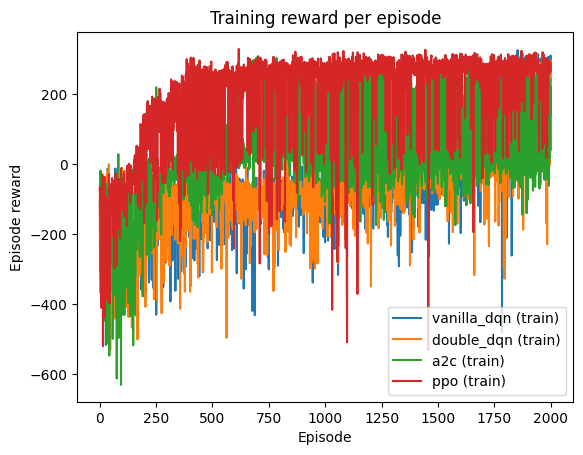

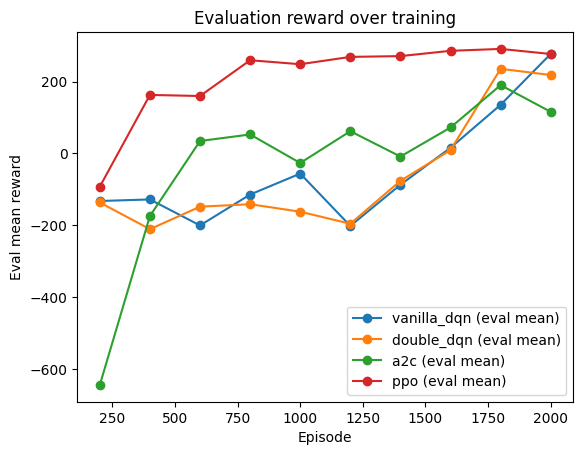

In [ ]:
plot_training_curves(results)
plot_eval_curves(results)


In [ ]:
tbl = summary_table(results)
tbl


,algorithm,episodes_logged,best_train_reward,best_eval_mean,last_eval_mean,elapsed_min,metrics_csv,model_path
3,ppo,2000,329.2,290.8,276.7,10.112310,runs_colab/ppo/metrics.csv,runs_colab/ppo/ppo_best.pt
0,vanilla_dqn,2000,325.5,277.0,277.0,13.374223,runs_colab/vanilla_dqn/metrics.csv,runs_colab/vanilla_dqn/vanilla_dqn_best.pt
1,double_dqn,2000,314.2,235.4,218.1,12.962594,runs_colab/double_dqn/metrics.csv,runs_colab/double_dqn/double_dqn_best.pt
2,a2c,2000,304.7,190.0,115.6,16.664094,runs_colab/a2c/metrics.csv,runs_colab/a2c/a2c_best.pt


In [ ]:
VIDEO_DIR = ROOT_OUT / "videos"
ensure_dir(VIDEO_DIR)

video_paths = {}

for alg in ["vanilla_dqn", "double_dqn", "a2c", "ppo"]:
    print("\n" + "-"*70)
    print(f"Recording video for: {alg}")

    ns = namespaces[alg]
    rr = results[alg]

    mp4 = record_video(
        ns=ns,
        alg_name=alg,
        env_id=OVERRIDES[alg]["ENV_ID"],
        model_path=rr.model_path,
        video_dir=VIDEO_DIR / alg,
        n_episodes=2,
    )
    video_paths[alg] = mp4
    print("Saved:", mp4)

print("\nDone recording.")



----------------------------------------------------------------------
Recording video for: vanilla_dqn
[vanilla_dqn] Can't record video: model not found at runs_colab/vanilla_dqn/vanilla_dqn_best.pt
Saved: None

----------------------------------------------------------------------
Recording video for: double_dqn
[double_dqn] Can't record video: model not found at runs_colab/double_dqn/double_dqn_best.pt
Saved: None

----------------------------------------------------------------------
Recording video for: a2c
[a2c] Can't record video: model not found at runs_colab/a2c/a2c_best.pt
Saved: None

----------------------------------------------------------------------
Recording video for: ppo
[ppo] Can't record video: model not found at runs_colab/ppo/ppo_best.pt
Saved: None

Done recording.


In [ ]:
for alg, mp4 in video_paths.items():
    print("\n" + "="*60)
    print("VIDEO:", alg)
    print("="*60)
    show_video(mp4, width=520)



VIDEO: vanilla_dqn

VIDEO: double_dqn

VIDEO: a2c

VIDEO: ppo
